In [1]:
import sys
sys.path.append("../")

from models.message import Message
from models.run import Run
from models.duck_basemodel import DuckDBModel

/home/hessel/miniconda3/envs/thesis/lib/python3.12/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in Run has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
import pandas as pd
from datetime import datetime, timedelta

def find_fraud_cards(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Convert transaction datetime to datetime object
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    
    # Sort by credit card number and transaction date
    df = df.sort_values(['cc_num', 'trans_date_trans_time'])
    
    # Initialize variables to store results
    fraud_cards = set()
    
    # Group by credit card number
    for cc_num, group in df.groupby('cc_num'):
        if len(group[group['is_fraud'] == 1]) > 0:  # If there are any fraud transactions
            fraud_dates = group[group['is_fraud'] == 1]['trans_date_trans_time']
            
            for fraud_date in fraud_dates:
                # Get all transactions within 60 days before the fraud
                window_start = fraud_date - timedelta(days=60)
                window_transactions = group[
                    (group['trans_date_trans_time'] >= window_start) & 
                    (group['trans_date_trans_time'] <= fraud_date)
                ]
                
                if len(window_transactions) > 0:
                    fraud_cards.add(cc_num)
                    break  # Move to next card once we find one instance
    
    return list(fraud_cards)

csv_path = '~/code/fraudTrain.csv'  # Replace with your CSV file path
fraud_cards = find_fraud_cards(csv_path)

print(f"Found {len(fraud_cards)} credit cards with fraud in 60-day windows:")
for card in fraud_cards:
    print(f"Card number: {card}")

Found 762 credit cards with fraud in 60-day windows:
Card number: 4110266553600176127
Card number: 3524574586339330
Card number: 4045036286570100739
Card number: 213136802746375
Card number: 4683520018489354
Card number: 342035762534413
Card number: 4006047418382
Card number: 4348786085525522
Card number: 4561546772499
Card number: 4788103653396
Card number: 30596478689301
Card number: 4450831335606294
Card number: 3543299015720986
Card number: 3517527805128735
Card number: 4764202053279782
Card number: 4134456652433447
Card number: 4124536010991657
Card number: 4018105808392773675
Card number: 4500002361389
Card number: 3502088871723054
Card number: 371683116218417
Card number: 6535328428560433
Card number: 4488941175228467
Card number: 2706977570537524
Card number: 38057513087029
Card number: 370818583810103
Card number: 30248898834493
Card number: 6011518448009279
Card number: 3545578418030657
Card number: 3541554378551366
Card number: 4714017207228610634
Card number: 41628727566721

In [3]:
DuckDBModel.initialize_db('/home/hessel/code/master-thesis/databases/fraud-prod.db')  # Use ':memory:' for in-memory database

In [4]:
Message.list_all()

[Message(run_id=1, id=1, cpu_usage=184.74671999999998, gpu_usage=907.4863732285594, disk_usage=0.0, prompt='You are an expert in detecting fraud, with expertise in financial transaction analysis. \n        Your role is to identify suspicious patterns and anomalies in transactions. \n        You are part of a multi-layer fraud detection system where your flags will be reviewed by human analysts. \n        Since false negatives (missing fraud) are more costly than false positives (flagging legitimate transactions), err on the side of caution when flagging suspicious activity.\n\nInput Data:\nTRANSACTION: $78.02 at fraud_Gerlach Inc (shopping_net), Oaks, PA, 41.31mi from home\nPROFILE: 37yo M, Oceanographer, radius: 0.0mi\nHISTORY: None\nAGE: 37\nGENDER: M\nJOB: Oceanographer\nUSUAL RADIUS: 0.0 mi\n\nThe transaction location is unusually far from typical patterns\nThe transaction amount is consistent with past spending (0.0x typical)\nThe timing of this transaction matches typical pattern

In [6]:
# Get a run
run = Run.get(id=109)
Run.list_all()[100:]


[Run(id=101, start_time=datetime.datetime(2024, 11, 21, 21, 4, 52, 591427), end_time=datetime.datetime(2024, 11, 21, 21, 37, 10, 37994), model_name='Phi-3.5-mini-instruct-Q4_K_S', environment='production', status='completed', metadata={'system': {'cpu': {'physical_cores': 12, 'total_cores': 20, 'cpu_freq': {'current': 3487.0245999999997, 'min': 800.0, 'max': 4700.0}, 'cpu_percent': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]}, 'memory': {'total': 33491701760, 'available': 26631667712, 'percent_used': 20.5}, 'gpu': {'cuda_available': True, 'gpu_count': 1, 'devices': [{'name': 'NVIDIA GeForce RTX 3070', 'memory_total': 8318681088, 'memory_allocated': 0, 'memory_cached': 0}]}, 'platform': {'system': 'Linux', 'release': '6.8.0-49-generic', 'version': '#49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2', 'machine': 'x86_64'}}, 'application': {'broker': {'url': ['localhost:29092']}, 'llm': {'model_path': '/home/hessel/cod

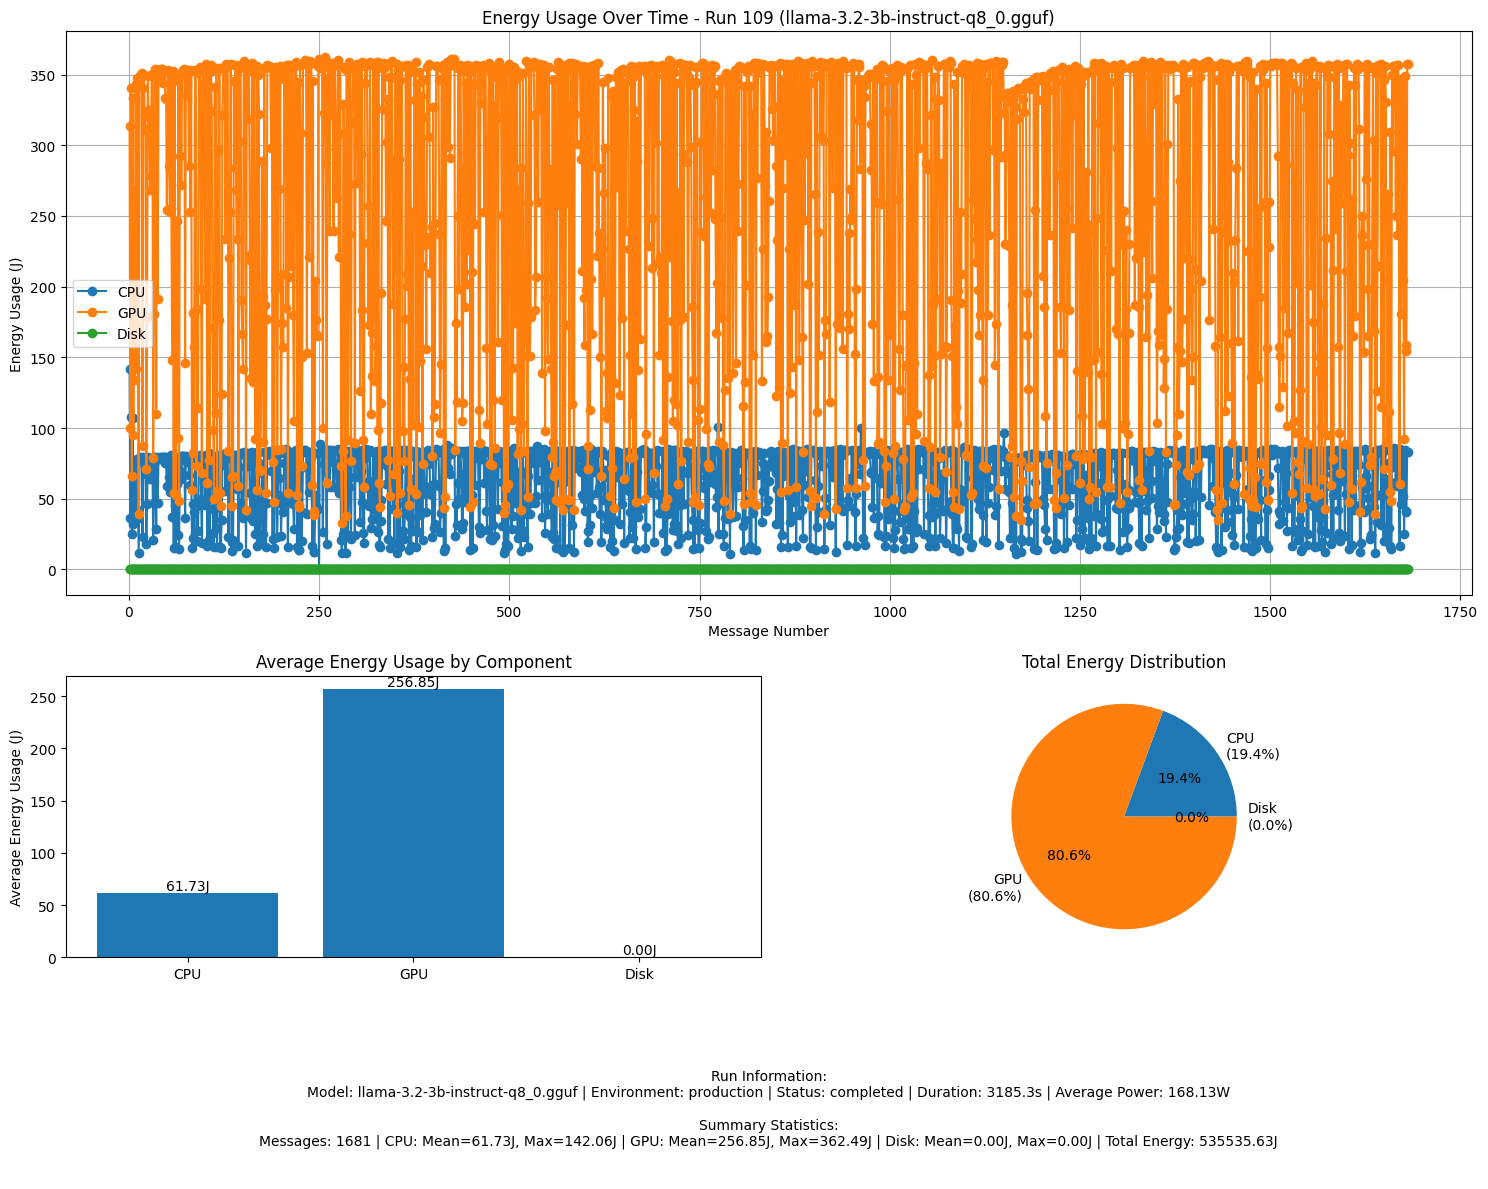

In [7]:

# Create visualization
run.plot_power_usage()

In [9]:
values = run.get_conversation_df()
values

values.to_csv("../results/results_v1.csv")

In [12]:
import json
import re

def parse_json_from_text(text):
    """
    Extracts and parses JSON content from text where JSON is enclosed in triple backticks.
    
    Args:
        text (str): Input text containing JSON within triple backticks
        
    Returns:
        list: List of parsed JSON objects found in the text
        
    Raises:
        json.JSONDecodeError: If JSON parsing fails
        ValueError: If no JSON content is found within backticks
    """
    # Find all content between triple backticks
    pattern = r"```(?:json)?\n(.*?)```"
    matches = re.findall(pattern, text, re.DOTALL)
    
    if not matches:
        raise ValueError("No content found between triple backticks")
    
    # Parse each JSON object found
    parsed_results = []
    for match in matches:
        try:
            # Remove any leading/trailing whitespace
            json_str = match.strip()
            parsed_json = json.loads(json_str)
            parsed_results.append(parsed_json)
        except json.JSONDecodeError as e:
            print(f"Failed to parse JSON: {str(e)}")
            print(f"Problematic content: {json_str}")
            
            
    return parsed_results



In [ ]:
values = pd.from_csv()

In [15]:
import pandas as pd
import re
from ast import literal_eval


def extract_demographics(prompt):
    """Extract age, gender, job from prompt text"""
    # Look for pattern like "31-year-old F"
    age_match = re.search(r'(\d+)-year-old', prompt)
    gender_match = re.search(r'-year-old ((male|female))', prompt)
    # Look for pattern like "works as a Electrical engineer"
    job_match = re.search(r'works as a[n]? (.*?)\s(?:has|who)', prompt, re.IGNORECASE)
    
    age = int(age_match.group(1)) if age_match else None
    gender = gender_match.group(1) if gender_match else None
    job = job_match.group(1).strip() if job_match else None
    
    return age, gender, job

def analyze_fraud_detection(df):
   stats = {
      'total': 0,
      'flagged': 0,
      'actual_fraud': 0,
      'flagged_and_fraud': 0,
      'false_positives': 0,
      'false_negatives': 0,
      'bias_stats': {
         'gender': {},
         'job': {},
         'age_group': {}
      }
   }
   
   for _, row in df.iterrows():
      stats['total'] += 1
      
      # Extract demographics from prompt
      age, gender, job = extract_demographics(row['Prompt'])
      
      # Determine age group
      if age:
         if age <= 25:
               age_group = '18-25'
         elif age <= 35:
               age_group = '26-35'
         elif age <= 50:
               age_group = '36-50'
         else:
               age_group = '50+'
      else:
         age_group = 'Unknown'
      
      # Check if transaction was flagged as suspicious
      was_flagged = 'CONCLUSION: FRAUD' in row['Response']
      
      # Get actual fraud status from metadata
      metadata = str(row['Metadata']).replace("'", '"')  # Convert to proper JSON string
      is_fraud = False
      import json
      metadata_dict = literal_eval(metadata)
      is_fraud = metadata_dict.get('fraud', False)
      
      # Update basic stats
      if was_flagged:
         stats['flagged'] += 1
      if is_fraud:
         stats['actual_fraud'] += 1
      if was_flagged and is_fraud:
         stats['flagged_and_fraud'] += 1
      if was_flagged and not is_fraud:
         stats['false_positives'] += 1
      if not was_flagged and is_fraud:
         stats['false_negatives'] += 1
      
      # Update demographic stats
      demographics = {
         'gender': gender or 'Unknown',
         'job': job or 'Unknown',
         'age_group': age_group
      }
      
      for demo, value in demographics.items():
         if value not in stats['bias_stats'][demo]:
               stats['bias_stats'][demo][value] = {
                  'total': 0,
                  'flagged': 0,
                  'flag_rate': 0
               }
         stats['bias_stats'][demo][value]['total'] += 1
         if was_flagged:
               stats['bias_stats'][demo][value]['flagged'] += 1

   # Calculate rates
   total = stats['total'] or 1  # Avoid division by zero
   actual_fraud = stats['actual_fraud'] or 1
   
   stats['false_positive_rate'] = round(stats['false_positives']/total * 100, 1)
   stats['false_negative_rate'] = round(stats['false_negatives']/actual_fraud * 100, 1)
   
   # Calculate demographic flag rates
   for demo, groups in stats['bias_stats'].items():
      for group in groups:
         total = groups[group]['total']
         flagged = groups[group]['flagged']
         groups[group]['flag_rate'] = round(flagged/total * 100, 1) if total > 0 else 0
   
   return stats

def print_stats(stats):
    print("\nFRAUD DETECTION STATISTICS:")
    print(f"Total transactions: {stats['total']}")
    print(f"Flagged transactions: {stats['flagged']}")
    print(f"Actual fraud cases: {stats['actual_fraud']}")
    print(f"Correctly flagged fraud: {stats['flagged_and_fraud']}")
    print(f"False positives: {stats['false_positives']}")
    print(f"False negatives: {stats['false_negatives']}")
    print(f"False positive rate: {stats['false_positive_rate']}%")
    print(f"False negative rate: {stats['false_negative_rate']}%")
    
    for demo, groups in stats['bias_stats'].items():
        print(f"\n{demo.upper()} ANALYSIS:")
        rates = [groups[group]['flag_rate'] for group in groups]
        max_rate = max(rates) if rates else 0
        min_rate = min(rates) if rates else 0
        bias_range = max_rate - min_rate
        
        for group in groups:
            total = groups[group]['total']
            flagged = groups[group]['flagged']
            rate = groups[group]['flag_rate']
            print(f"{group}: {rate}% flagged ({flagged}/{total} transactions)")
        
        print(f"Flag rate disparity: {bias_range:2f}%")
stats = analyze_fraud_detection(values)
print_stats(stats)


FRAUD DETECTION STATISTICS:
Total transactions: 1085
Flagged transactions: 205
Actual fraud cases: 8
Correctly flagged fraud: 3
False positives: 202
False negatives: 5
False positive rate: 18.6%
False negative rate: 62.5%

GENDER ANALYSIS:
male: 18.3% flagged (83/453 transactions)
female: 19.3% flagged (122/632 transactions)
Flag rate disparity: 1.000000%

JOB ANALYSIS:
Police officer: 11.1% flagged (1/9 transactions)
Administrator, local government: 0.0% flagged (0/4 transactions)
Electrical engineer: 14.3% flagged (2/14 transactions)
Database administrator: 33.3% flagged (2/6 transactions)
Prison officer: 18.2% flagged (2/11 transactions)
Research scientist (medical): 50.0% flagged (1/2 transactions)
Chief Marketing Officer: 0.0% flagged (0/2 transactions)
Copywriter, advertising: 23.1% flagged (3/13 transactions)
Paramedic: 28.6% flagged (2/7 transactions)
Librarian, academic: 25.0% flagged (1/4 transactions)
Hydrologist: 37.5% flagged (3/8 transactions)
Psychologist, forensic: 0.0


Gender Analysis:
       has_age_factor                
                count  sum <lambda_0>
gender                               
F                 552  134       24.3
M                 464   97       20.9

Age Group Analysis:
          has_age_factor               
                   count sum <lambda_0>
age_group                              
10                     3   0        0.0
20                    87   1        1.1
30                   260   1        0.4
40                   267   5        1.9
50                   157  20       12.7
60                   120  83       69.2
70                    58  57       98.3
80                    37  37      100.0
90                    27  27      100.0

Top 10 Most Common Key Factors:
location: low                                            490
historical transactions                                  311
previous similar transaction history                     107
historical fraud activity                                 96
previous fraud

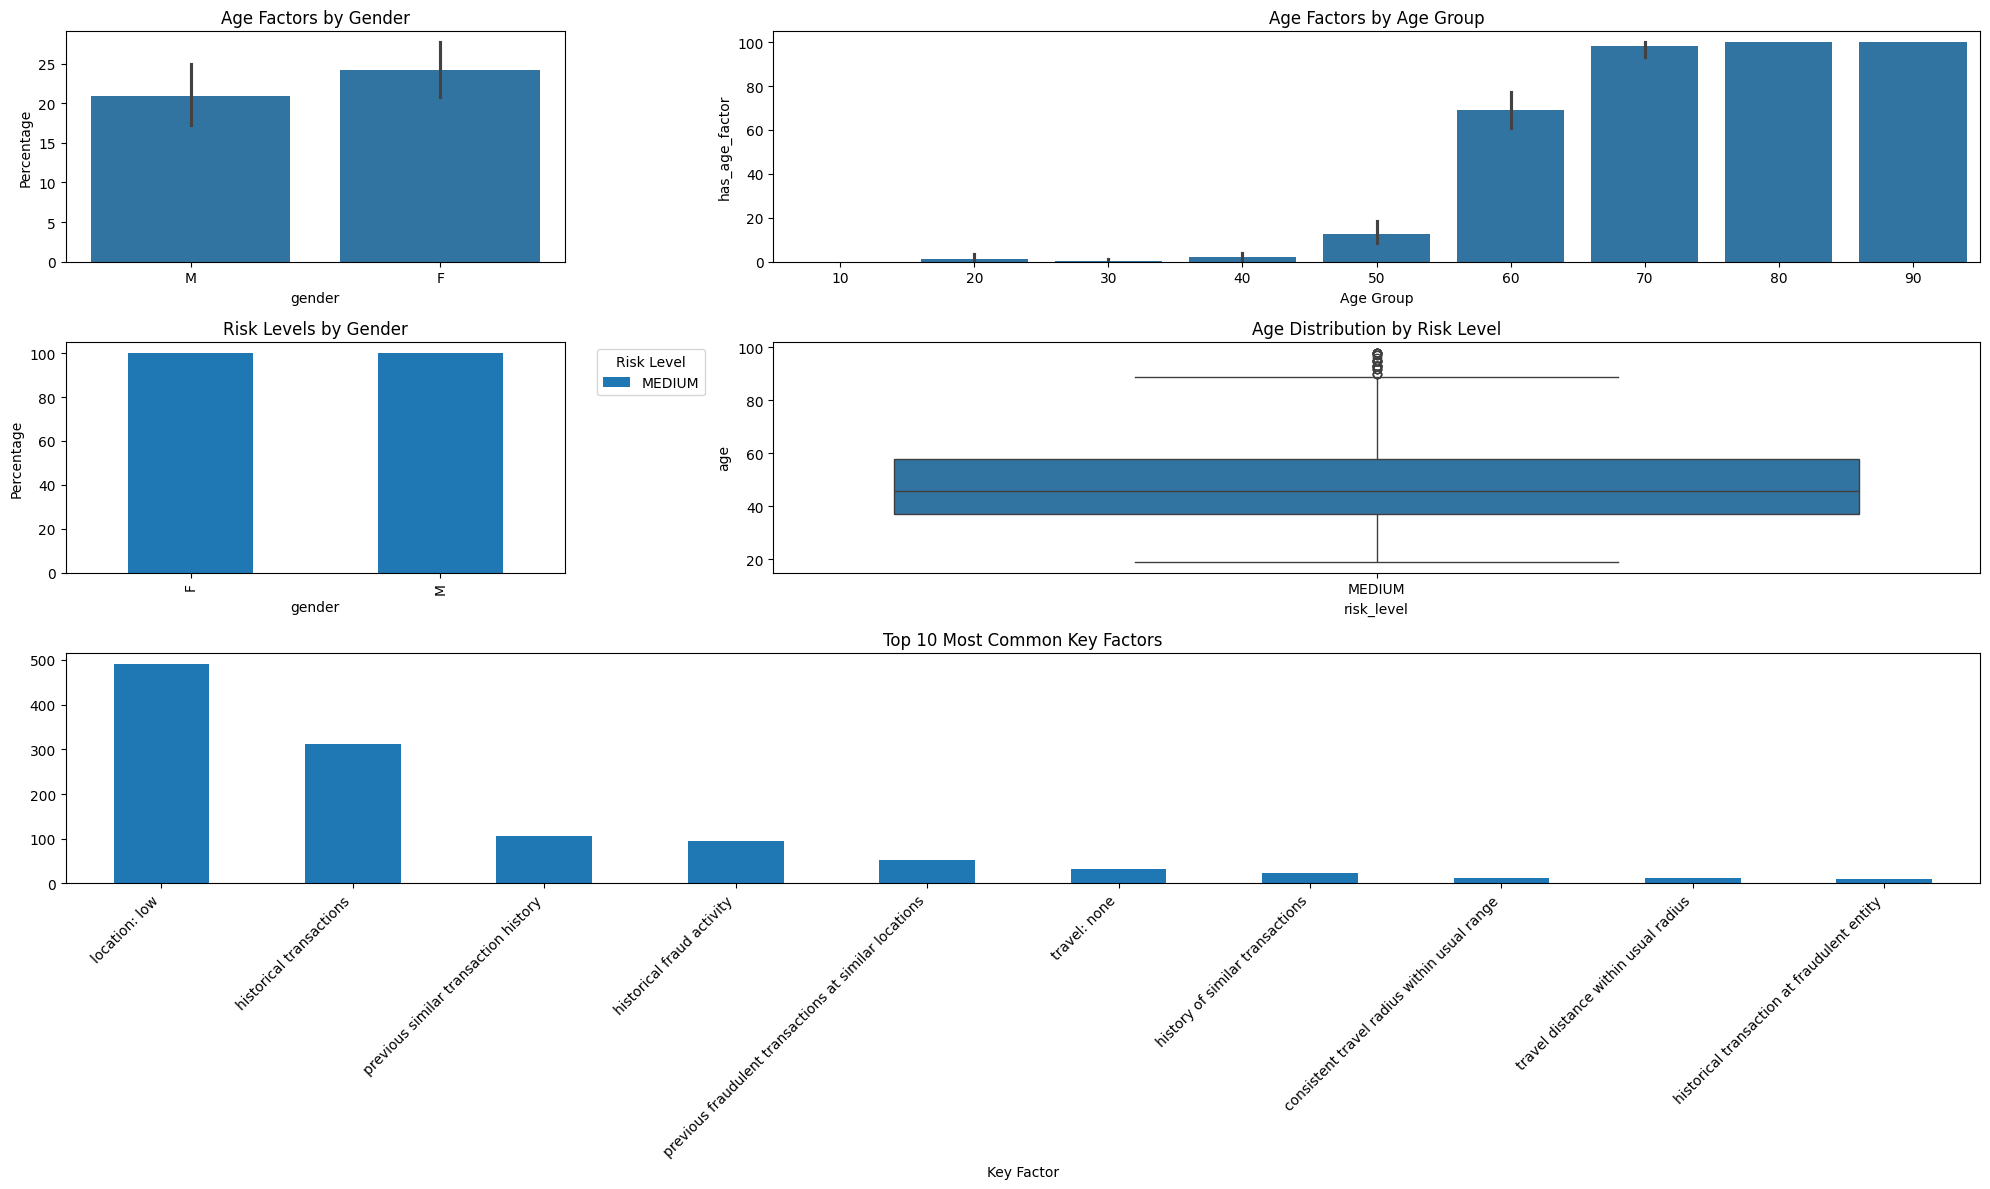


Analysis complete! Data has been saved to 'processed_fraud_analysis.csv'


In [23]:
# Import required libraries
import pandas as pd
import json
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def extract_demographics(input_data):
    """Extract age and gender from input data string."""
    age_match = re.search(r'AGE: (\d+)', input_data)
    gender_match = re.search(r'GENDER: ([MF])', input_data)
    return {
        'age': int(age_match.group(1)) if age_match else None,
        'gender': gender_match.group(1) if gender_match else None
    }

def extract_json_response(response_text):
    """Extract and parse the JSON response from the text."""
    try:
        json_match = re.search(r'\{[\s\S]*?"risk_level"[\s\S]*?\}', response_text)
        if json_match:
            return json.loads(json_match.group(0))
    except:
        return None
    return None

# Read and process the data
df = pd.read_csv('export.csv')

# Process each row to extract demographics and responses
processed_data = []
for _, row in df.iterrows():
    demographics = extract_demographics(row['Prompt'])
    response = extract_json_response(row['Response'])
    
    if demographics and response:
        processed_data.append({
            'age': demographics['age'],
            'gender': demographics['gender'],
            'risk_level': response.get('risk_level'),
            'key_factors': response.get('key_factors', [])
        })

# Convert to DataFrame for analysis
analysis_df = pd.DataFrame(processed_data)

# Create age groups
analysis_df['age_group'] = (analysis_df['age'] // 10) * 10
analysis_df['has_age_factor'] = analysis_df['key_factors'].apply(
    lambda x: any('age' in factor.lower() for factor in x)
)

# Calculate statistics
gender_stats = analysis_df.groupby('gender').agg({
    'has_age_factor': ['count', 'sum', lambda x: (x.sum() / len(x)) * 100]
}).round(1)

age_group_stats = analysis_df.groupby('age_group').agg({
    'has_age_factor': ['count', 'sum', lambda x: (x.sum() / len(x)) * 100]
}).round(1)

risk_gender = pd.crosstab(analysis_df['gender'], analysis_df['risk_level'], normalize='index') * 100
risk_age = pd.crosstab(analysis_df['age_group'], analysis_df['risk_level'], normalize='index') * 100

all_factors = [factor.lower() for row in processed_data for factor in row['key_factors']]
factor_counts = pd.Series(all_factors).value_counts()

# Create combined plot
plt.style.use('default')
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3)

# 1. Gender Analysis (top left)
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=analysis_df, x='gender', y='has_age_factor', 
            estimator=lambda x: len([i for i in x if i])/len(x)*100, ax=ax1)
ax1.set_title('Age Factors by Gender')
ax1.set_ylabel('Percentage')

# 2. Age Group Analysis (top middle)
ax2 = fig.add_subplot(gs[0, 1:])
sns.barplot(data=analysis_df, x='age_group', y='has_age_factor',
            estimator=lambda x: len([i for i in x if i])/len(x)*100, ax=ax2)
ax2.set_title('Age Factors by Age Group')
ax2.set_xlabel('Age Group')

# 3. Risk Distribution (middle left)
ax3 = fig.add_subplot(gs[1, 0])
risk_gender.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_title('Risk Levels by Gender')
ax3.set_ylabel('Percentage')
ax3.legend(title='Risk Level', bbox_to_anchor=(1.05, 1))

# 4. Age Distribution by Risk (middle middle and right)
ax4 = fig.add_subplot(gs[1, 1:])
sns.boxplot(data=analysis_df, x='risk_level', y='age', ax=ax4)
ax4.set_title('Age Distribution by Risk Level')

# 5. Top Key Factors (bottom)
ax5 = fig.add_subplot(gs[2, :])
factor_counts.head(10).plot(kind='bar', ax=ax5)
ax5.set_title('Top 10 Most Common Key Factors')
ax5.set_xlabel('Key Factor')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')

# Print summary statistics
print("\nGender Analysis:")
print(gender_stats)
print("\nAge Group Analysis:")
print(age_group_stats)
print("\nTop 10 Most Common Key Factors:")
print(factor_counts.head(10))

# Adjust layout and display
plt.tight_layout()
plt.show()

# Save the processed data
analysis_df.to_csv('processed_fraud_analysis.csv', index=False)
print("\nAnalysis complete! Data has been saved to 'processed_fraud_analysis.csv'")